In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, LabelEncoder,
    OneHotEncoder, PolynomialFeatures, OrdinalEncoder
)
from pandas.core.arrays import categorical
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    SelectKBest, f_regression, mutual_info_regression
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_openml

import warnings
warnings.filterwarnings('ignore')

# Plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

print("All imports successful!")

All imports successful!


In [16]:
df = pd.read_csv("insurance.csv")

# Get basic statistics about the dataset
print("Dataset shape:", df.shape)
print("\nColumn data types:")
print(df.dtypes)

print("\nBasic statistics for numeric columns:")
print(df.describe())


Dataset shape: (1338, 7)

Column data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Basic statistics for numeric columns:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


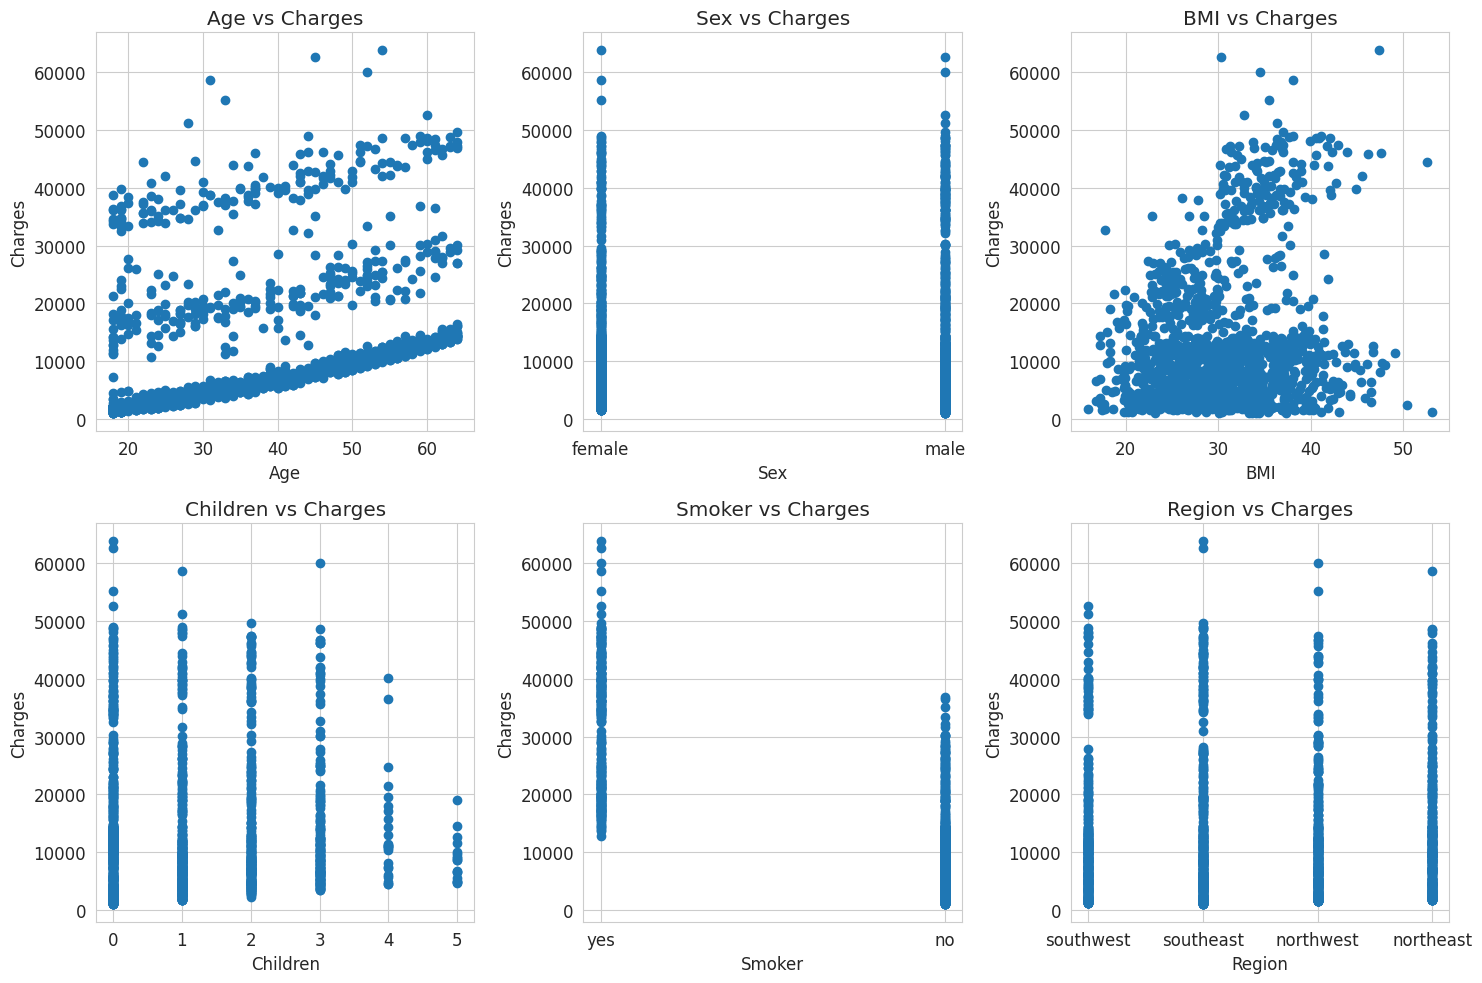

In [17]:
#Exploratory Data Analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#Plot 1: age vs charges
axes[0,0].scatter(df['age'], df['charges'])
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Charges')
axes[0,0].set_title('Age vs Charges')

#Plot 2: sex vs charges
axes[0,1].scatter(df['sex'], df['charges'])
axes[0,1].set_xlabel('Sex')
axes[0,1].set_ylabel('Charges')
axes[0,1].set_title('Sex vs Charges')

#Plot 3: bmi vs charges
axes[0,2].scatter(df['bmi'], df['charges'])
axes[0,2].set_xlabel('BMI')
axes[0,2].set_ylabel('Charges')
axes[0,2].set_title('BMI vs Charges')

#Plot 4: children vs charges
axes[1,0].scatter(df['children'], df['charges'])
axes[1,0].set_xlabel('Children')
axes[1,0].set_ylabel('Charges')
axes[1,0].set_title('Children vs Charges')

#Plot 5: smoker vs charges
axes[1,1].scatter(df['smoker'], df['charges'])
axes[1,1].set_xlabel('Smoker')
axes[1,1].set_ylabel('Charges')
axes[1,1].set_title('Smoker vs Charges')

#Plot 6: region vs charges
axes[1,2].scatter(df['region'], df['charges'])
axes[1,2].set_xlabel('Region')
axes[1,2].set_ylabel('Charges')
axes[1,2].set_title('Region vs Charges')

plt.tight_layout()
plt.show()

In [18]:
# ============================================================
# Check for missing values — ALWAYS your first step
# ============================================================
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_summary = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)

print("Columns with missing values:")
print("=" * 50)
print(missing_summary[missing_summary['Missing Count'] > 0].to_string())
print(f"\nTotal: {(missing > 0).sum()} columns have missing data")
print(f"Total missing cells: {df.isnull().sum().sum()} "
      f"out of {df.shape[0] * df.shape[1]} ({df.isnull().sum().sum() / (df.shape[0]*df.shape[1]) * 100:.1f}%)")

Columns with missing values:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

Total: 0 columns have missing data
Total missing cells: 0 out of 9366 (0.0%)


In [19]:
X = df.drop('charges', axis=1)
y = df['charges']

categorical_cols = ["sex","smoker","region"]
numeric_cols = ["age","bmi","children"]

In [20]:
# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_cols),
        ('num', "passthrough", numeric_cols)
    ]
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} clients")
print(f"Test set: {len(X_test)} clients")
print(f"\nCategorical Features: {categorical_cols}")
print(f"Numeric Features: {numeric_cols}")

Training set: 1070 clients
Test set: 268 clients

Categorical Features: ['sex', 'smoker', 'region']
Numeric Features: ['age', 'bmi', 'children']


In [21]:
# Build decision tree
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

dt_pipeline.fit(X_train, y_train)

y_pred_dt = dt_pipeline.predict(X_test)

# Evaluate
train_acc = dt_pipeline.score(X_train, y_train)
test_acc = dt_pipeline.score(X_test, y_test)
r2_dt = r2_score(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)

print(f"Training Accuracy: {train_acc:.3f} ({train_acc*100:.1f}%)")
print(f"Test Accuracy: {test_acc:.3f} ({test_acc*100:.1f}%)")
print(f"r2 score: {r2_dt:.3f}")
print(f"MAE: {mae_dt:.3f}")

Training Accuracy: 0.998 (99.8%)
Test Accuracy: 0.727 (72.7%)
r2 score: 0.727
MAE: 3195.110


In [22]:
# Cross Validation
cv_scores = cross_val_score(
    dt_pipeline, X_train, y_train,
    cv=5,
    scoring='r2'
)
print(f"Baseline Cross-Validation RMSE: {cv_scores.mean():.3f}")

Baseline Cross-Validation RMSE: 0.678


In [23]:
# Hyperparameter Tuning
depth_values = [None, 1, 2, 3, 4, 5, 10, 20, 30]

best_depth = None
best_r2 = float(0)
best_mae = float('inf')

depth_results = {}

for depth in depth_values:
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("model", DecisionTreeRegressor(max_depth=depth, random_state=42))
    ])

    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='r2'
    )

    mean_r2 = cv_scores.mean()
    depth_results[depth] = mean_r2

    print(f"Depth: {depth}, Mean R2: {mean_r2:.3f}")

    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_depth = depth

print("\nBest Depth: ", best_depth)
print(f"Best R2: {best_r2:.3f}")

Depth: None, Mean R2: 0.678
Depth: 1, Mean R2: 0.603
Depth: 2, Mean R2: 0.819
Depth: 3, Mean R2: 0.836
Depth: 4, Mean R2: 0.837
Depth: 5, Mean R2: 0.821
Depth: 10, Mean R2: 0.715
Depth: 20, Mean R2: 0.678
Depth: 30, Mean R2: 0.678

Best Depth:  4
Best R2: 0.837


In [24]:
# Build Model with best depth
final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeRegressor(max_depth=best_depth, random_state=42))
])

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.3}")


Test Set Metrics:
RMSE: 4592.76
MAE: 2697.77
R2 Score: 0.864


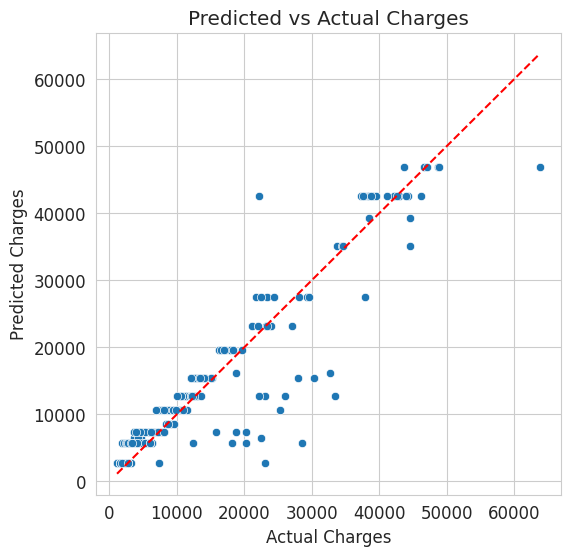

In [25]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Actual Charges")
plt.show()

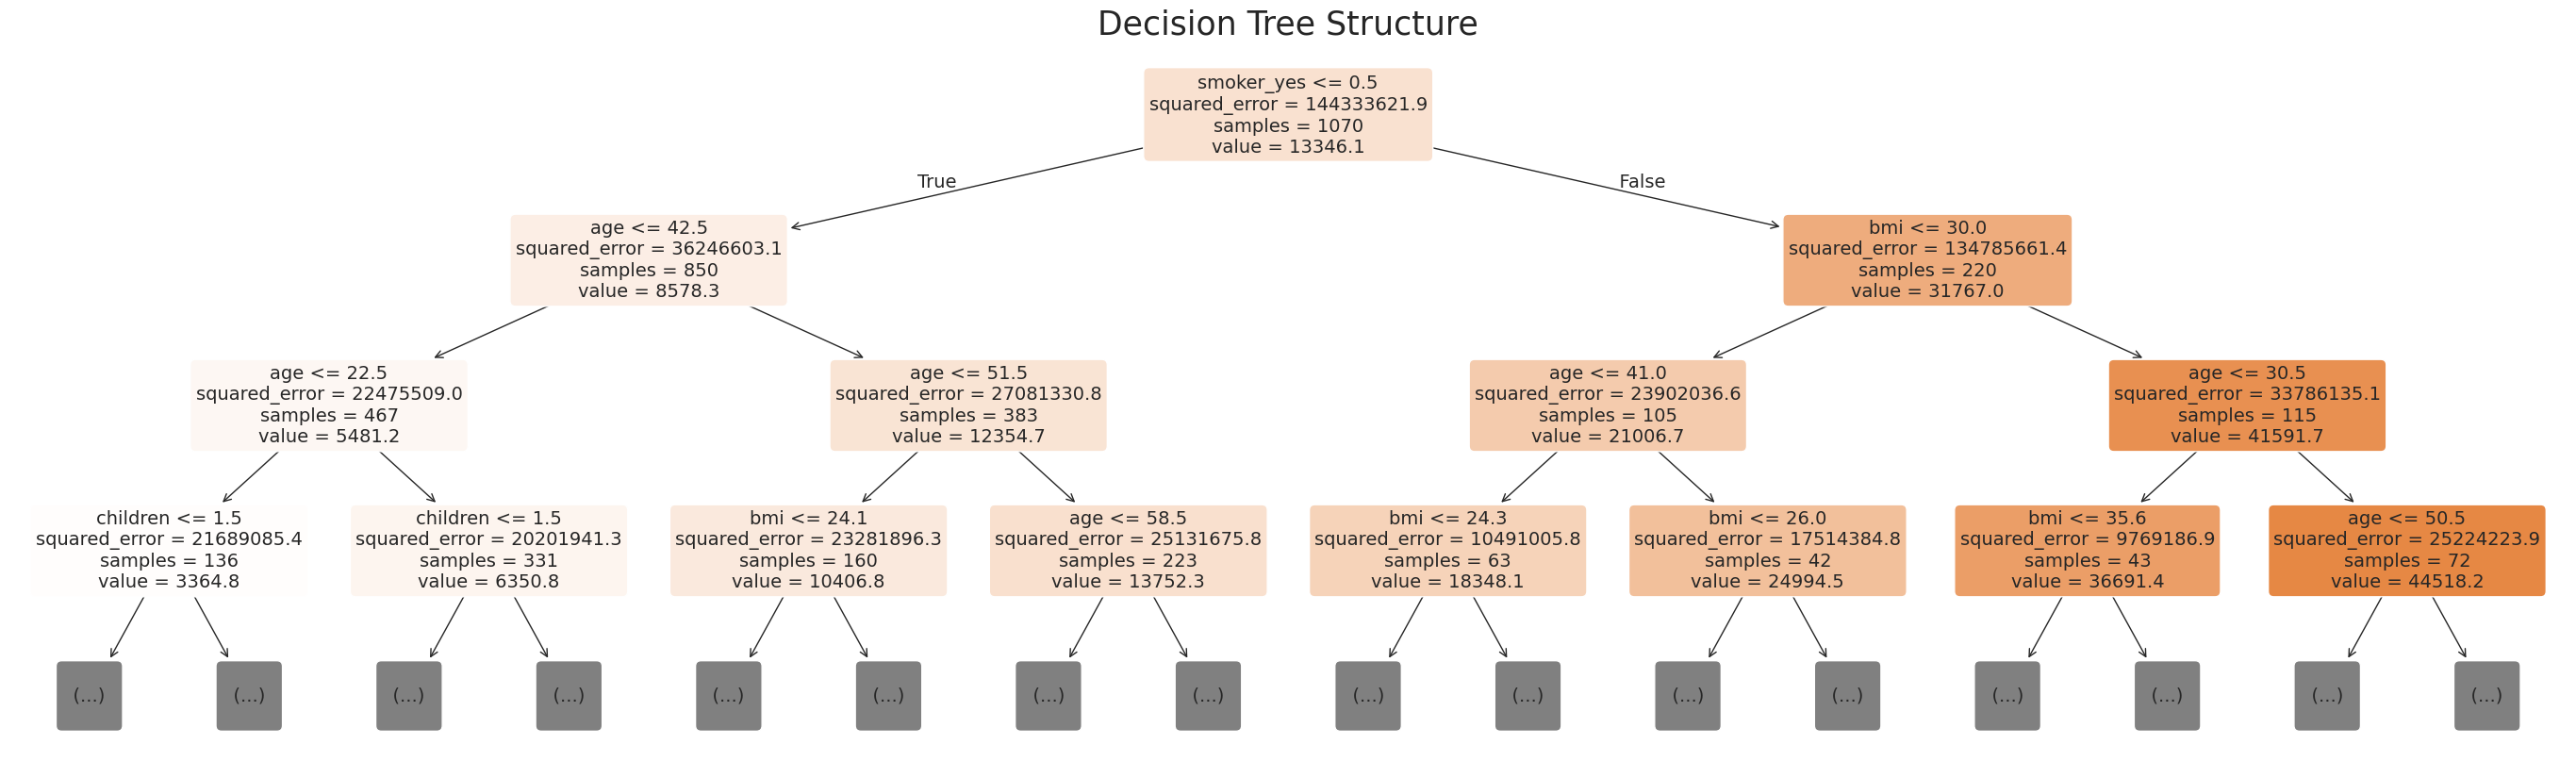

In [49]:
# Extract trained decion tree
tree_model = final_model.named_steps['model']

# Get feature names after preprocessing
ohe = final_model.named_steps['preprocessor'] \
                 .named_transformers_['cat']

encoded_cat_features = ohe.get_feature_names_out(categorical_cols)

all_feature_names = list(encoded_cat_features) + numeric_cols

# Visualizing full decision tree
plt.figure(figsize=(35,10))

plot_tree(
    tree_model,
    feature_names=all_feature_names,
    filled=True,
    rounded=True,
    fontsize=14,
    max_depth=3,
    precision=1
)

plt.title("Decision Tree Structure", fontsize=25)
plt.show()


Feature Importance:
            Feature  Importance
1        smoker_yes    0.703212
6               bmi    0.178707
5               age    0.114492
7          children    0.003589
3  region_southeast    0.000000
2  region_northwest    0.000000
0          sex_male    0.000000
4  region_southwest    0.000000


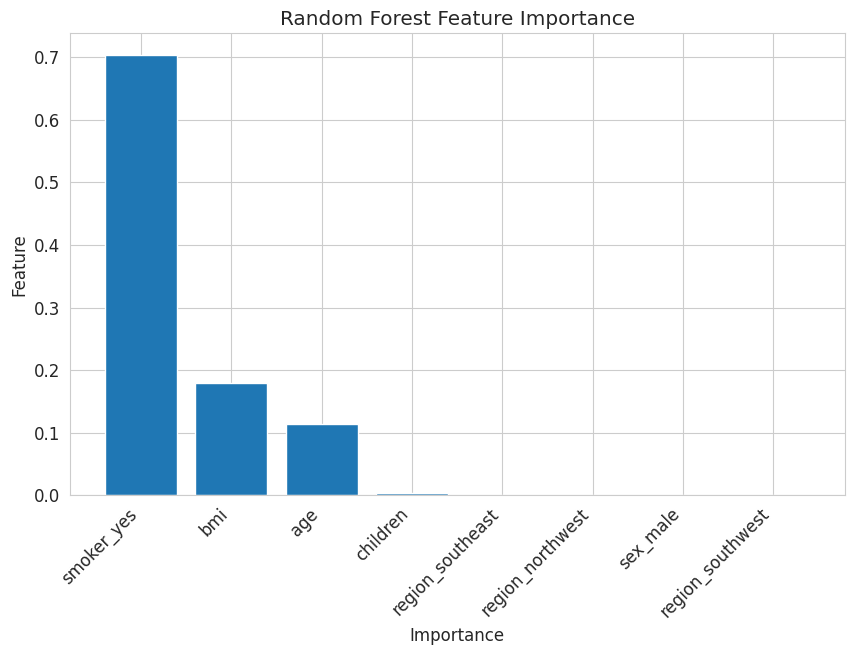

In [42]:
# Feature Importance
importances = tree_model.feature_importances_

# Sort features
importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Plot feature importance
plt.figure()
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=45, ha='right')
plt.show()